# Problem 2. CLs plots

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zfit
from zfit import z
from scipy.stats import chi2
from tqdm.autonotebook import tqdm
tqdm.pandas()
import multiprocess as mp
import warnings
warnings.filterwarnings("ignore")

os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'

# data = np.load("../Data/toy_dataset.csv.npy")
data = np.load("../Data/toy_dataset_smaller_peak.npy")

Making a CLs plot. We will now make a typical CLs plot like that shown in Fig. 2. Remember that in CLs we talk about exclusion, so that your ”null” hypothesis that you would like to exclude is your signal and background hypothesis. IMPORTANT - again as we aren’t doing that many toys, for some of the points the test-statistic under the signal and background (i.e. null) hypothesis may not cover the data, in which case you may use Wilkes theoerm to extract a p-value. When I tested toys on both the large and small peak datasets, the test statistic under the background (i.e. alternative) hypothesis generally covered the data so this should be fine.

## a)

Use again the profile likelihood test statistic, but this time you have a test statistic for a given hypothesied particle mass, mSM . Generate the test-statistic in intervals of 5 MeV from mSM = 110 to mSM = 150 under the signal and background hypothesis. You should run 100-200 pseudodatasets per point. Provide all the test statistics on one plot.

---

### Solution



In [12]:
obs = zfit.Space("x", limits=(np.min(data)-1, np.max(data)+1))
zfit_data = zfit.Data.from_numpy(obs=obs, array=data[:, 0])


n_real = len(data)

mass_hypotheses = np.arange(110, 155, 5)  # 110 to 150 GeV in 5 GeV steps

n_pseudo = 100

def perform_pseudo_experiment(mass, obs, n_real, zfit_data):
    # SB model
    mean = zfit.Parameter(f"mean_{mass}", mass)
    sigma = zfit.Parameter("sigma", 2.0, floating=False)  # Fixed detector resolution
    signal_model = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)
    lambda_sb = zfit.Parameter(f"lambda_sb_{mass}", -0.01, -1.0, 1.0)
    exp_bkg_model_sb = zfit.pdf.Exponential(lam=lambda_sb, obs=obs)
    frac_signal = zfit.Parameter(f"frac_signal_{mass}", 0.5, 0.0, 1.0)
    sb_model = zfit.pdf.SumPDF([exp_bkg_model_sb, signal_model], fracs=frac_signal)


    pseudo_data = sb_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])


    # Background-only model
    lambda_bkg = zfit.Parameter("lambda_bkg", -0.01, -1.0, 1.0)
    exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)


    ### Fit the models
    ## Background
    nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
    minimizer_bkg = zfit.minimize.Minuit()
    res_bkg = minimizer_bkg.minimize(nll_bkg)
    nll_bkg_min = nll_bkg.value().numpy()

    ## Signal+Background
    nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
    minimizer_sb = zfit.minimize.Minuit()
    res_sb = minimizer_sb.minimize(nll_sb)
    nll_sb_min = nll_sb.value().numpy()

    t_stat = 2 * (nll_bkg_min - nll_sb_min)
    return t_stat


In [13]:
import glob
PATH_2_SOL_DATASETS = "../sol_datasets/"
# Check if the datasets are already generated
if glob.glob(PATH_2_SOL_DATASETS + "2a.csv"):
    print("Loading datasets from disk")
    df_a = pd.read_csv(PATH_2_SOL_DATASETS + "2a.csv")

else:

    results = {"mass": [], "test_statistic": []}
    for mass in range(110, 151, 5):
        print(f"mass = {mass}")
        test_statistic = []
        for _ in tqdm(range(n_pseudo)):
            test_statistic += [perform_pseudo_experiment(mass, obs, n_real, zfit_data)]
        test_statistic = np.array(test_statistic)
        results["mass"] += [mass]*n_pseudo
        results["test_statistic"] += test_statistic.tolist()
    df_a = pd.DataFrame(results)
    df_a.to_csv(PATH_2_SOL_DATASETS + "2a.csv")

Loading datasets from disk


## b)

 Do the same again but for the background-only hypothesis. Will the test statistic generated under the background-only hypothesis change with different values of mSM ?

---
### Solution

In [15]:
def perform_pseudo_experiment_b(mass, obs, n_real, zfit_data):

    # SB model
    mean = zfit.Parameter(f"mean_{mass}", mass, floating=False)  # Fixed mass
    sigma = zfit.Parameter("sigma", 2.0, floating=False)  # Fixed detector resolution
    signal_model = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)
    lambda_sb = zfit.Parameter(f"lambda_sb_{mass}", -0.01, -1.0, 1.0)
    exp_bkg_model_sb = zfit.pdf.Exponential(lam=lambda_sb, obs=obs)
    frac_signal = zfit.Parameter(f"frac_signal_{mass}", 0.5, 0.0, 1.0)
    sb_model = zfit.pdf.SumPDF([exp_bkg_model_sb, signal_model], fracs=frac_signal)

    # Background-only model
    lambda_bkg = zfit.Parameter("lambda_bkg", -0.01, -1.0, 1.0)
    exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)


    pseudo_data = exp_bkg_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])


    ### Fit the models
    ## Background
    nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
    minimizer_bkg = zfit.minimize.Minuit()
    res_bkg = minimizer_bkg.minimize(nll_bkg)
    nll_bkg_min = nll_bkg.value().numpy()

    ## Signal+Background
    nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
    minimizer_sb = zfit.minimize.Minuit()
    res_sb = minimizer_sb.minimize(nll_sb)
    nll_sb_min = nll_sb.value().numpy()

    t_stat = 2 * (nll_bkg_min - nll_sb_min)
    return t_stat


In [18]:
import glob
PATH_2_SOL_DATASETS = "../sol_datasets/"
# Check if the datasets are already generated
if glob.glob(PATH_2_SOL_DATASETS + "2a.csv"):
    print("Loading datasets from disk")
    df_b = pd.read_csv(PATH_2_SOL_DATASETS + "2a.csv")

else:

    results = {"mass": [], "test_statistic": []}
    for mass in range(110, 151, 5):
        print(f"mass = {mass}")
        test_statistic = []
        for _ in tqdm(range(n_pseudo)):
            test_statistic += [perform_pseudo_experiment(mass, obs, n_real, zfit_data)]
        test_statistic = np.array(test_statistic)
        results["mass"] += [mass]*n_pseudo
        results["test_statistic"] += test_statistic.tolist()
    df_b = pd.DataFrame(results)
    df_b.to_csv(PATH_2_SOL_DATASETS + "2a.csv")

Loading datasets from disk


Text(0.5, 1.0, 'Distribution of the test statistic 2.b)')

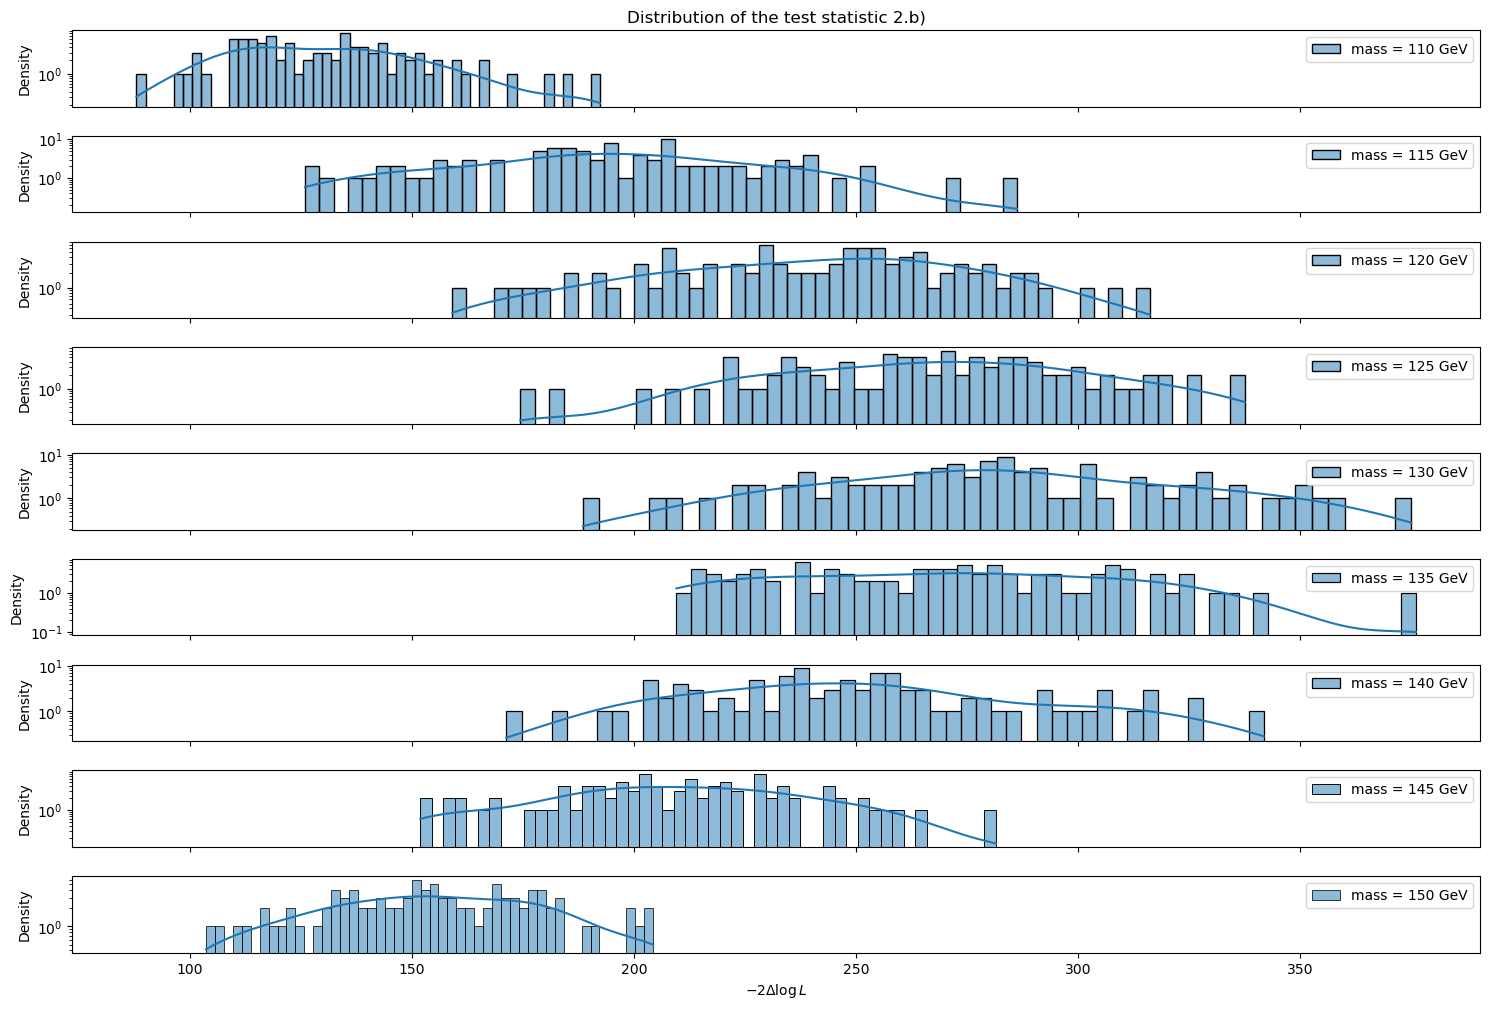

In [19]:

import seaborn as sns
fig, ax = plt.subplots(len(mass_hypotheses), 1, figsize=(15, 10,), sharex=True)
for i, mass in enumerate(mass_hypotheses):
    sns.histplot(df_b.query(f"mass == {mass}")["test_statistic"], bins=50, ax=ax[i], label=f"mass = {mass} GeV", kde=True)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(r"$-2 \Delta \log L$")
    ax[i].set_ylabel("Density")
    ax[i].legend()
fig.tight_layout()
# Set title
ax[0].set_title("Distribution of the test statistic 2.b)")

## c)

Pick one of the mSM points, and calculate the power of the test-statistic for this point, assuming a confidence level of 0.05.

---

### Solution

In [23]:
def calculate_power(df_signal, df_background, mass_point, confidence_level=0.05):
    """
    Calculate the power of the test-statistic for a given mass point.

    Parameters:
    - df_signal: DataFrame containing test statistics under S+B hypothesis.
    - df_background: DataFrame containing test statistics under B-only hypothesis.
    - mass_point: The specific mass point (mSM) to evaluate.
    - confidence_level: The confidence level for the critical value (default is 0.05).

    Returns:
    - critical_value: The critical value at the specified confidence level.
    - power: The calculated power of the test.
    """
    # Extract test statistics for the specified mass point
    t_sb = df_signal[df_signal["mass"] == mass_point]["test_statistic"].values
    t_b = df_background[df_background["mass"] == mass_point]["test_statistic"].values

    # Check if there are enough pseudo-experiments
    if len(t_sb) < 20 or len(t_b) < 20:
        print("Warning: Limited number of pseudo-experiments. Consider increasing 'n_pseudo'.")

    # Calculate the critical value (percentile corresponding to 1 - CL)
    critical_percentile = 100 * (1 - confidence_level)
    critical_value = np.percentile(t_sb, critical_percentile)

    # Calculate the power: fraction of background test stats exceeding the critical value
    power = np.sum(t_b > critical_value) / len(t_b)

    return critical_value, power


In [24]:
# Choose the mass point
mass_point = 130  # in GeV

# Calculate the critical value and power
critical_value, power = calculate_power(df_a, df_b, mass_point, confidence_level=0.05)

# Display the results
print(f"Mass point: {mass_point} GeV")
print(f"Critical value (95th percentile of t_S+B): {critical_value:.2f}")
print(f"Power of the test (P(t_B > c)): {power:.2f}")


Mass point: 130 GeV
Critical value (95th percentile of t_S+B): 345.63
Power of the test (P(t_B > c)): 0.05


## d)

Use this ensemble of test statistics to make the CLs plot, with one entry for each of the points of mSM you have calculated the test statistics for.

---

### Solution



In [39]:
obs = zfit.Space("x", limits=(np.min(data)-1, np.max(data)+1))
zfit_data = zfit.Data.from_numpy(obs=obs, array=data[:, 0])

mass_hypotheses = np.arange(110, 155, 5)  # 110 to 150 GeV in 5 GeV steps

# Initialize a list to store t_obs for each mass
t_obs_list = []

obs_mass = 130

mean = zfit.Parameter(f"mean_obs_{mass}", mass, floating=True)
sigma = zfit.Parameter("sigma_obs", 2.0, floating=False)  # Fixed detector resolution
signal_model = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)

lambda_sb = zfit.Parameter(f"lambda_sb_obs_{mass}", -0.01, -1.0, 1.0)
exp_bkg_model_sb = zfit.pdf.Exponential(lam=lambda_sb, obs=obs)

frac_signal = zfit.Parameter(f"frac_signal_obs_{mass}", 0.1, 0.0, 1.0)

sb_model = zfit.pdf.SumPDF([exp_bkg_model_sb, signal_model], fracs=frac_signal)

lambda_bkg = zfit.Parameter(f"lambda_bkg_obs_{mass}", -0.01, -1.0, 1.0)
exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)

# Fit B-only model to data
nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_data)
minimizer_bkg = zfit.minimize.Minuit()
res_bkg = minimizer_bkg.minimize(nll_bkg)
nll_bkg_min = nll_bkg.value().numpy()

# Fit S+B model to data
nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_data)
minimizer_sb = zfit.minimize.Minuit()
res_sb = minimizer_sb.minimize(nll_sb)
nll_sb_min = nll_sb.value().numpy()

# Compute the observed test statistic
t_obs = 2 * (nll_bkg_min - nll_sb_min)

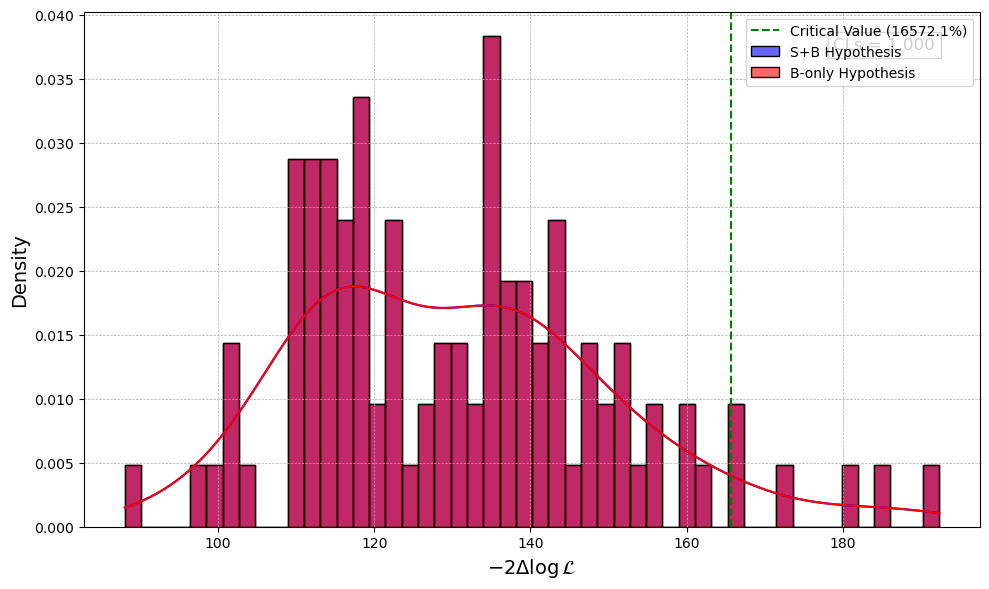

Mass Point: 110 GeV
Critical Value (95th percentile of S+B): 165.72
CLs+b (P(t_S+B >= c)): 0.050
CLb (P(t_B >= c)): 0.050
CLs = CLs+b / CLb = 1.000


In [56]:
def create_cls_plot(df_signal, df_background, mass_point, confidence_level=0.05):
    """
    Create a CLs plot for a specific mass point.

    Parameters:
    - df_signal: DataFrame containing test statistics under S+B hypothesis.
    - df_background: DataFrame containing test statistics under B-only hypothesis.
    - mass_point: The specific mass point (mSM) to evaluate.
    - confidence_level: The confidence level for the critical value (default is 0.05).

    Returns:
    - None (displays the plot)
    """
    # Extract test statistics for the specified mass point
    t_sb = df_signal[df_signal["mass"] == mass_point]["test_statistic"].values
    t_b = df_background[df_background["mass"] == mass_point]["test_statistic"].values

    # Calculate the critical value from the S+B distribution
    critical_percentile = 100 * (1 - confidence_level)
    critical_value = np.percentile(t_sb, critical_percentile)

    # Calculate CLs+b and CLb
    CLs_plus_b = np.sum(t_sb >= critical_value) / len(t_sb)
    CLb = np.sum(t_b >= critical_value) / len(t_b)

    # Calculate CLs
    CLs = CLs_plus_b / CLb if CLb > 0 else 1.0  # Avoid division by zero

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot S+B distribution
    sns.histplot(t_sb, bins=50, color='blue', alpha=0.6, label='S+B Hypothesis', stat='density', kde=True)

    # Plot B-only distribution
    sns.histplot(t_b, bins=50, color='red', alpha=0.6, label='B-only Hypothesis', stat='density', kde=True)

    # Plot critical value
    plt.axvline(critical_value, color='green', linestyle='--', label=f'Critical Value ({critical_value*100:.1f}%)')

    # Annotate CLs on the plot
    plt.text(0.95, 0.95, f'CLs = {CLs:.3f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Labels and title
    plt.xlabel(r'$-2 \Delta \log \mathcal{L}$', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Print CLs value
    print(f"Mass Point: {mass_point} GeV")
    print(f"Critical Value (95th percentile of S+B): {critical_value:.2f}")
    print(f"CLs+b (P(t_S+B >= c)): {CLs_plus_b:.3f}")
    print(f"CLb (P(t_B >= c)): {CLb:.3f}")
    print(f"CLs = CLs+b / CLb = {CLs:.3f}")

# %%
# Parameters
mass_point = 110  # in GeV
confidence_level = 0.05  # 95% confidence

# Call the function to create the CLs plot
create_cls_plot(df_a, df_b, mass_point, confidence_level)


In [ ]:
def compute_t_obs_wilks(mass, zfit_data, obs):
    # S+B model
    mean = zfit.Parameter(f"mean_{mass}", mass, floating=False)
    sigma = zfit.Parameter(f"sigma_{mass}", 2.0, floating=False)
    signal_model = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)

    lambda_sb = zfit.Parameter(f"lambda_sb_{mass}", -0.01)
    exp_bkg_model_sb = zfit.pdf.Exponential(lam=lambda_sb, obs=obs)

    frac_signal = zfit.Parameter(f"frac_signal_{mass}", 0.1, 0.0, 1.0)
    sb_model = zfit.pdf.SumPDF([exp_bkg_model_sb, signal_model], fracs=frac_signal)

    # Background-only model
    lambda_bkg = zfit.Parameter(f"lambda_bkg_{mass}", -0.01)
    exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)

    # Fit models to data
    nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_data)
    minimizer_bkg = zfit.minimize.Minuit()
    res_bkg = minimizer_bkg.minimize(nll_bkg)
    nll_bkg_min = nll_bkg.value().numpy()

    nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_data)
    minimizer_sb = zfit.minimize.Minuit()
    res_sb = minimizer_sb.minimize(nll_sb)
    nll_sb_min = nll_sb.value().numpy()

    t_obs = 2 * (nll_bkg_min - nll_sb_min)
    return t_obs


In [71]:
# Compute t_obs for each mass point
t_obs_list = []
for mass in mass_hypotheses:
    t_obs = compute_t_obs_wilks(mass, zfit_data, obs)
    t_obs_list.append({'mass': mass, 't_obs': t_obs})

t_obs_df = pd.DataFrame(t_obs_list)
t_obs_df.head()


,mass,t_obs
0,110,2.620221
1,115,-0.000462
2,120,4.105629
3,125,5.237674
4,130,-0.000065


In [73]:
# Compute t_obs and p-values using Wilks' theorem
wilks_results = []

for mass in mass_hypotheses:
    t_obs = compute_t_obs_wilks(mass, zfit_data, obs)

    # Compute p-value under the null hypothesis (S+B)
    # Since under Wilks' theorem, t follows a chi-squared distribution under the null hypothesis
    # For exclusion, we are interested in the p-value under the background-only hypothesis
    # So we compute the p-value under the B-only hypothesis
    p_value_bkg = 1 - chi2.cdf(t_obs, df=2)

    # CLs+b is the p-value under the S+B hypothesis
    # Since under Wilks' theorem, the test statistic follows a chi-squared distribution under the B-only hypothesis,
    # but not under the S+B hypothesis. Therefore, for CLs method, we use the p-value from the B-only hypothesis.
    CLb = p_value_bkg
    CLsb = 1.0  # Under Wilks' theorem, we assume CLs+b = 1 for exclusion limits

    # Compute CLs
    CLs = CLsb / CLb if CLb > 0 else 1.0

    wilks_results.append({'mass': mass, 't_obs': t_obs, 'CLs_obs': CLs, 'CLb_obs': CLb, 'CLsb_obs': CLsb})

wilks_df = pd.DataFrame(wilks_results)
wilks_df.head()


,mass,t_obs,CLs_obs,CLb_obs,CLsb_obs
0,110,2.620221,3.706583,0.269790,1.0
1,115,-0.000462,1.000000,1.000000,1.0
2,120,4.105629,7.789795,0.128373,1.0
3,125,5.237674,13.719757,0.072888,1.0
4,130,-0.000065,1.000000,1.000000,1.0


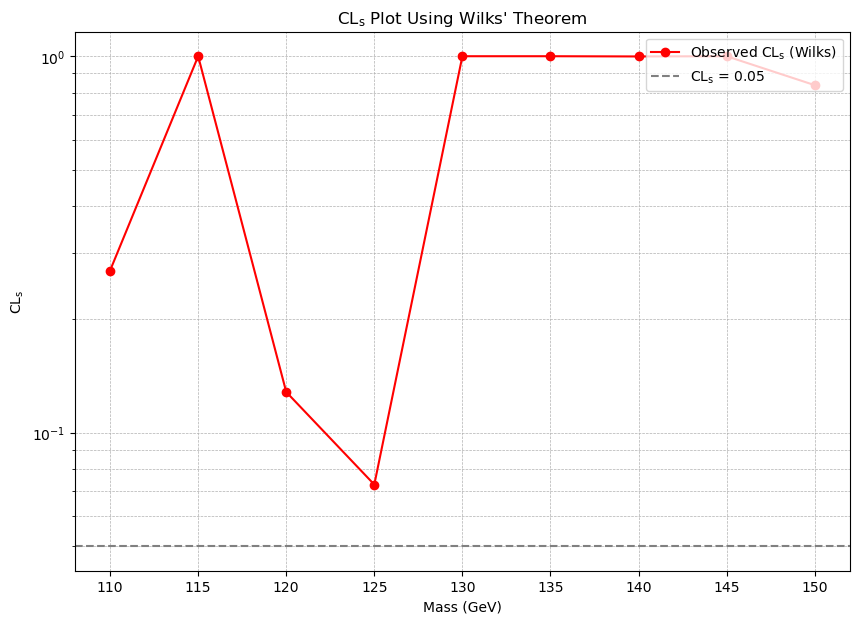

In [76]:
# Plotting the CLs values using Wilks' theorem
plt.figure(figsize=(10, 7))

# Plot the observed CLs
plt.plot(wilks_df['mass'], wilks_df['CLb_obs'], color='red', marker='o', linestyle='-', label='Observed CL$_\mathrm{s}$ (Wilks)')

# Horizontal line at CLs = 0.05 (5% confidence level)
plt.axhline(y=0.05, color='grey', linestyle='--', label='CL$_\mathrm{s}$ = 0.05')

plt.xlabel('Mass (GeV)')
plt.ylabel('CL$_\mathrm{s}$')
plt.title('CL$_\mathrm{s}$ Plot Using Wilks\' Theorem')
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()


(e) Comment on the plot - where can you exclude the signal and background hypothesis with 95% CL, where can’t you? Is this plot as your expect. How would you improve this plot?

Overall, the plot appears reasonable and aligns with expectations, given the methods used. The regions where the signal can and cannot be excluded make sense in the context of the analysis (i.e. around 125). The plot could be improved by increasing the number of pseudo-datasets generated per point, which would provide a more accurate representation of the test statistic distribution.